# InfoGAN



In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torchvision.transforms.v2 as T

from tqdm.notebook import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader

# Check for device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
###################################
#  Parameters
###################################
batch_size = 64
image_size = 28
channels = 1  # MNIST is grayscale

# Latent dimensions
z_dim = 62
c_cat_dim = 10
c_cont_dim = 2
latent_dim = z_dim + c_cat_dim + c_cont_dim  # 74

# Hyperparameters
lr = 2e-4
beta1 = 0.5
lambda_info = 1.0  # weight for mutual information loss

num_epochs = 20


In [3]:
###################################
#  Data
###################################
transform = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Normalize([0.5], [0.5])
])

mnist_datapath = '/pgeoprj2/ciag2024/dados/'
mnist_dataset = datasets.MNIST(mnist_datapath, train=True, download=True, transform=transform)
dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [4]:
###################################
#  Generator
###################################
class Generator(nn.Module):
    def __init__(self, latent_dim, channels=1):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            nn.Linear(1024, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.ReLU(True)
        )
        self.deconv = nn.Sequential(
            # reshape to (128,7,7)
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 7 -> 14
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, channels, kernel_size=4, stride=2, padding=1),  # 14 -> 28
            nn.Tanh()
        )

    def forward(self, x):
        out = self.fc(x)
        out = out.view(-1, 128, 7, 7)
        img = self.deconv(out)
        return img


In [5]:
###################################
#  Discriminator + Q Network
###################################
# The discriminator outputs a real/fake score.
# The Q network (attached) predicts the latent codes from the shared features.

class Discriminator(nn.Module):
    def __init__(self, channels=1):
        super(Discriminator, self).__init__()
        # Feature extraction layers
        self.conv = nn.Sequential(
            # Input: (channels, 28, 28)
            nn.Conv2d(channels, 64, kernel_size=4, stride=2, padding=1),  # 28->14
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 14->7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True)
        )
        # Discriminator head: real/fake output
        self.disc_head = nn.Sequential(
            nn.Conv2d(128, 1, kernel_size=7),  # 7x7 -> 1x1
            # Note: We'll use BCEWithLogitsLoss so no sigmoid here.
        )
        # Q network head: latent code prediction
        # For Q, we use a small network on top of the shared features.
        self.q_conv = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True)
        )

        # For discrete latent code: output logits for 10 classes, adjusted kernel size from 7 to 6
        self.q_cat = nn.Conv2d(128, c_cat_dim, kernel_size=6)  # output: 1x1 feature map per code
        # For continuous latent code: predict mean values; similarly adjust kernel size
        self.q_cont = nn.Conv2d(128, c_cont_dim, kernel_size=6)

    def forward(self, x):
        features = self.conv(x)  # shape: (batch,128,7,7)
        disc_logits = self.disc_head(features)  # shape: (batch,1,1,1)
        disc_logits = disc_logits.view(-1)  # flatten to (batch,)

        q_features = self.q_conv(features)  # shape: (batch,128,?,?)
        # Predict categorical codes
        q_cat_logits = self.q_cat(q_features).view(-1, c_cat_dim)  # shape: (batch,10)
        # Predict continuous codes (we assume Gaussian, so predict mean; variance can be fixed)
        q_cont_mu = self.q_cont(q_features).view(-1, c_cont_dim)  # shape: (batch,2)

        return disc_logits, q_cat_logits, q_cont_mu


In [6]:
###################################
#  Instantiate networks and optimizers
###################################
G = Generator(latent_dim=latent_dim, channels=channels).to(device)
D = Discriminator(channels=channels).to(device)

optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
# For the mutual information part, we'll update G (and Q parts in D) together.
optimizer_info = optim.Adam(list(G.parameters()) + list(D.parameters()), lr=lr, betas=(beta1, 0.999))

# Loss functions
criterion_adv = nn.BCEWithLogitsLoss()
criterion_cat = nn.CrossEntropyLoss()
criterion_cont = nn.MSELoss()  # For continuous latent codes


In [7]:
###################################
#  Utility functions
###################################
def sample_latent(batch_size):
    # Sample noise z from uniform [-1,1]
    z = torch.rand(batch_size, z_dim, device=device) * 2 - 1
    # Sample categorical code (integers in [0, c_cat_dim-1])
    cat_codes = torch.randint(0, c_cat_dim, (batch_size,), device=device)
    # One-hot encode categorical code
    cat_codes_onehot = torch.zeros(batch_size, c_cat_dim, device=device)
    cat_codes_onehot[torch.arange(batch_size), cat_codes] = 1
    # Sample continuous latent codes from uniform [-1,1]
    cont_codes = torch.rand(batch_size, c_cont_dim, device=device) * 2 - 1
    # Concatenate all latent parts: shape: (batch_size, latent_dim)
    latent = torch.cat([z, cat_codes_onehot, cont_codes], dim=1)
    return latent, cat_codes, cont_codes

def denorm(img):
    # Scale image tensor from [-1,1] to [0,1]
    return (img + 1) / 2

def show_images(images, nrow=8):
    grid = torchvision.utils.make_grid(images, nrow=nrow, normalize=True)
    npimg = grid.cpu().numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.axis("off")
    plt.show()


Starting training...


  0%|          | 0/938 [00:00<?, ?batch/s]

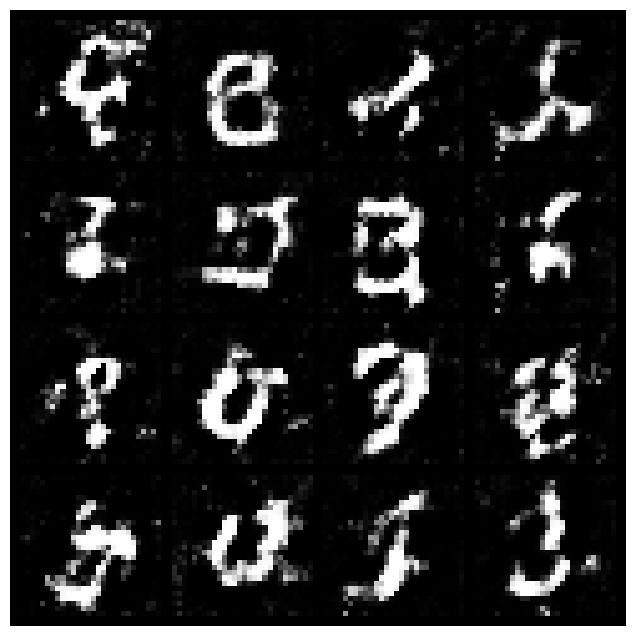

  0%|          | 0/938 [00:00<?, ?batch/s]

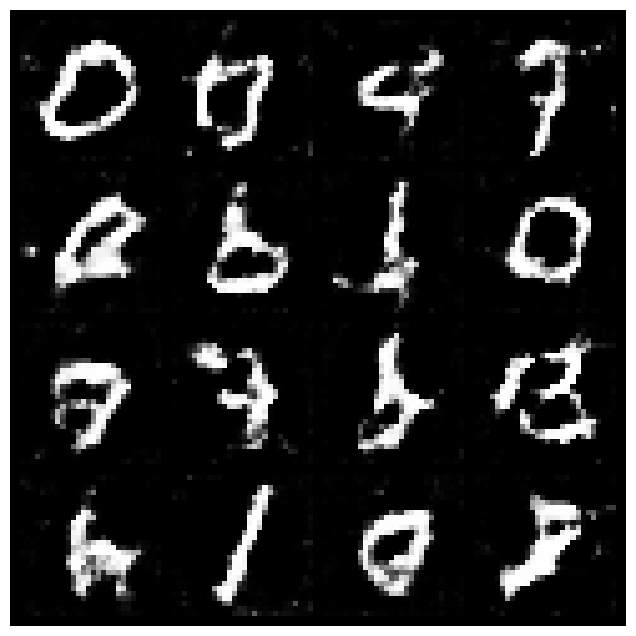

  0%|          | 0/938 [00:00<?, ?batch/s]

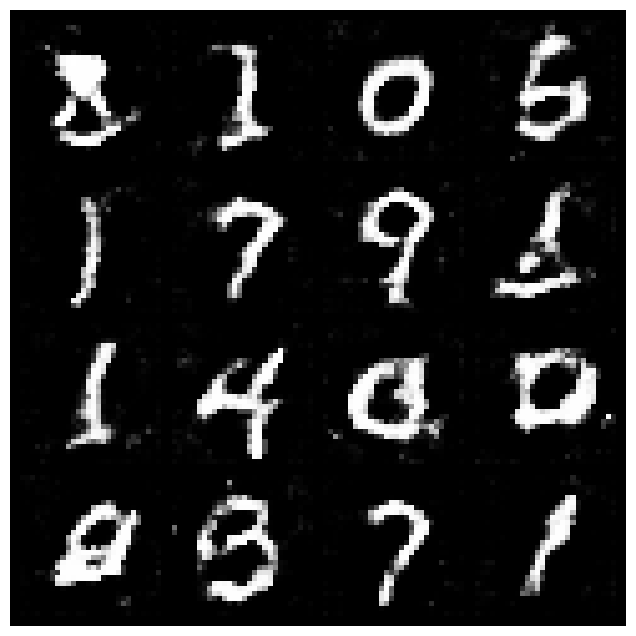

  0%|          | 0/938 [00:00<?, ?batch/s]

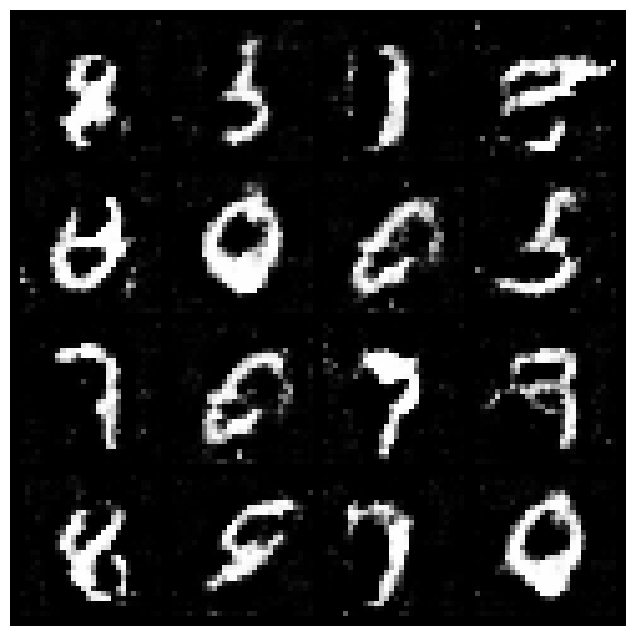

  0%|          | 0/938 [00:00<?, ?batch/s]

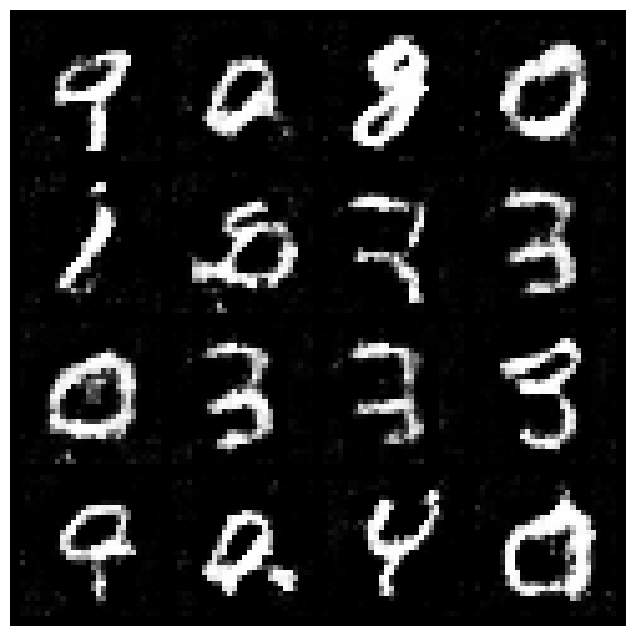

  0%|          | 0/938 [00:00<?, ?batch/s]

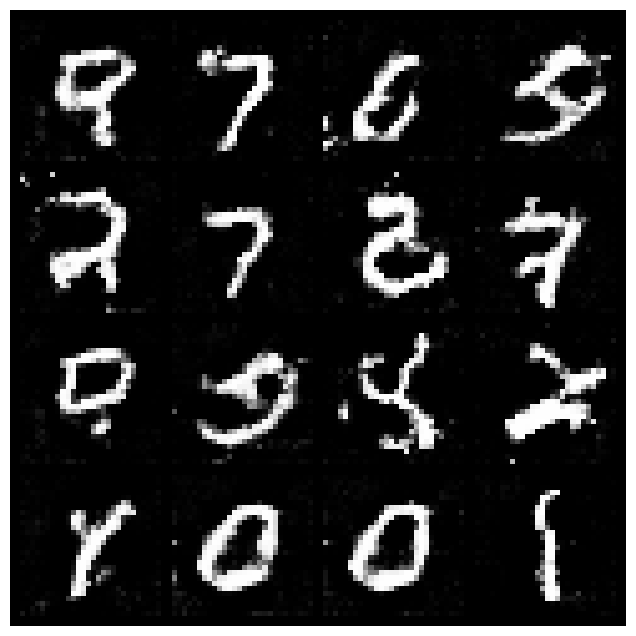

  0%|          | 0/938 [00:00<?, ?batch/s]

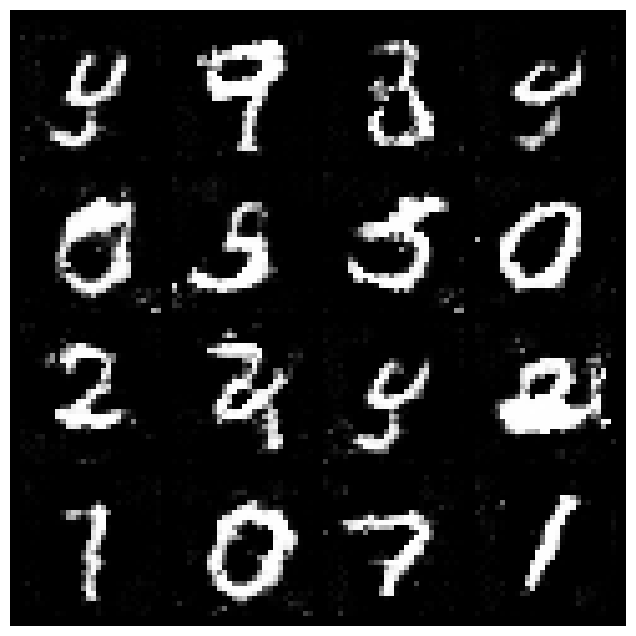

  0%|          | 0/938 [00:00<?, ?batch/s]

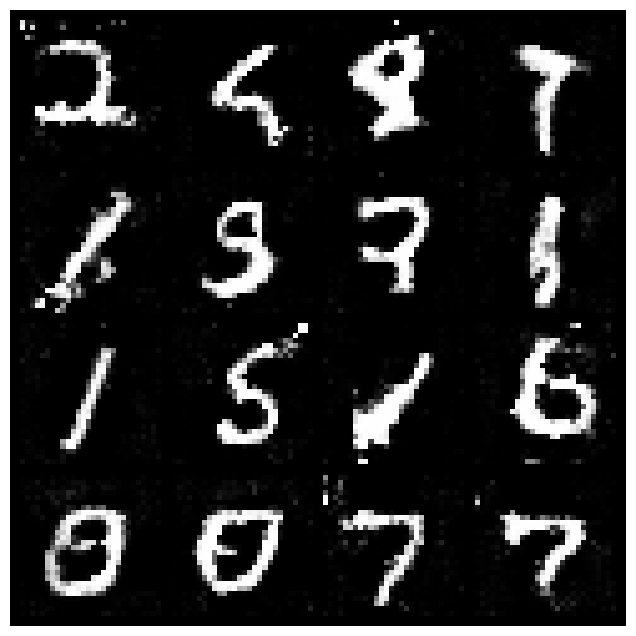

  0%|          | 0/938 [00:00<?, ?batch/s]

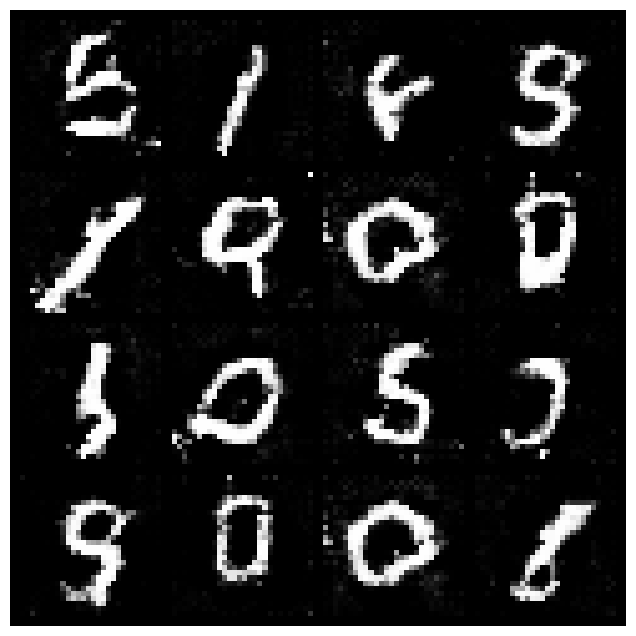

  0%|          | 0/938 [00:00<?, ?batch/s]

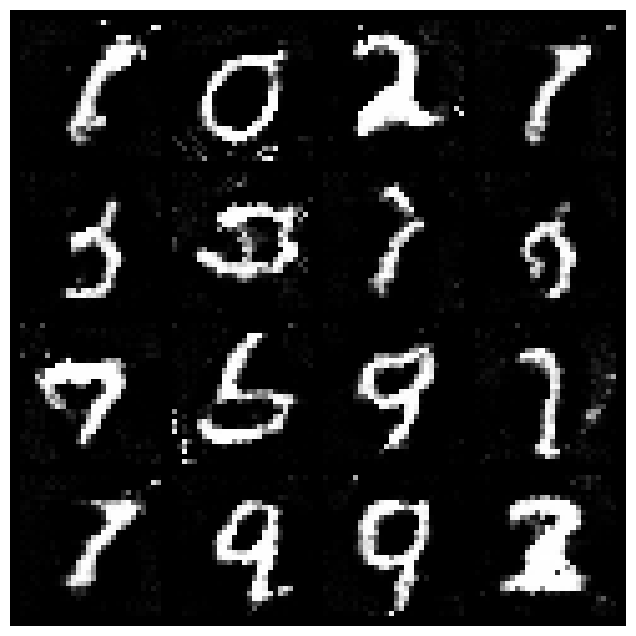

  0%|          | 0/938 [00:00<?, ?batch/s]

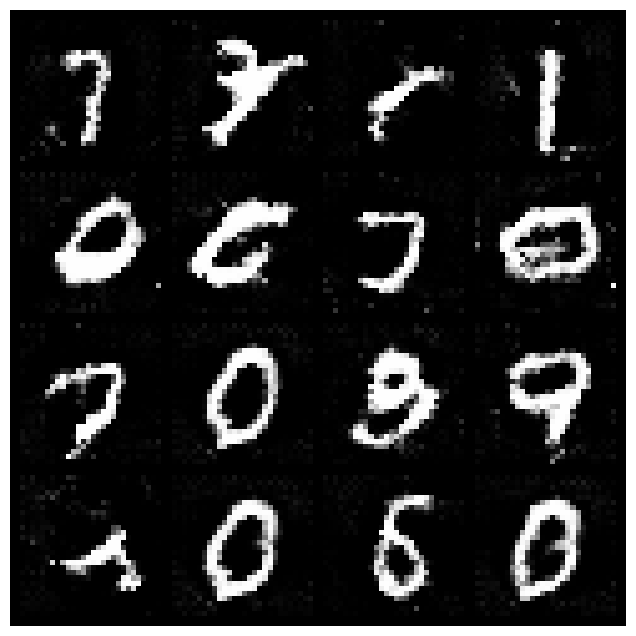

  0%|          | 0/938 [00:00<?, ?batch/s]

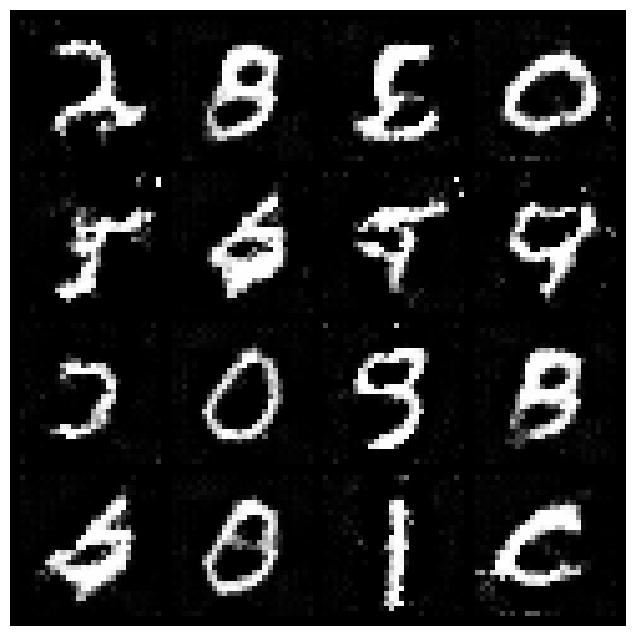

  0%|          | 0/938 [00:00<?, ?batch/s]

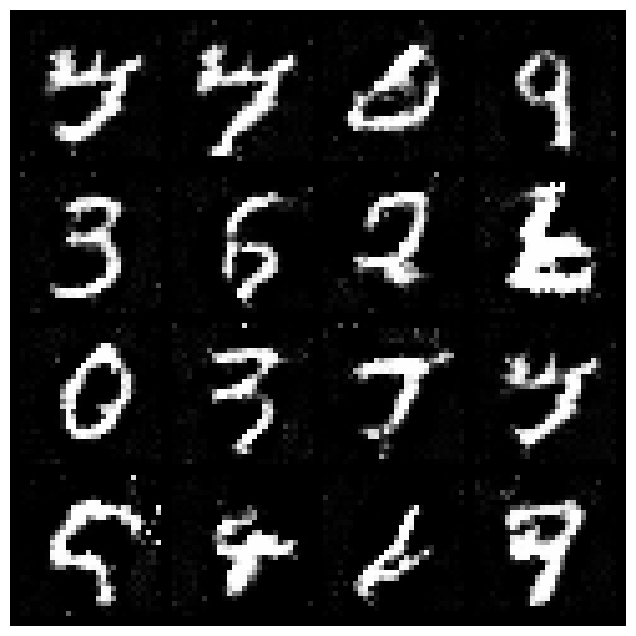

  0%|          | 0/938 [00:00<?, ?batch/s]

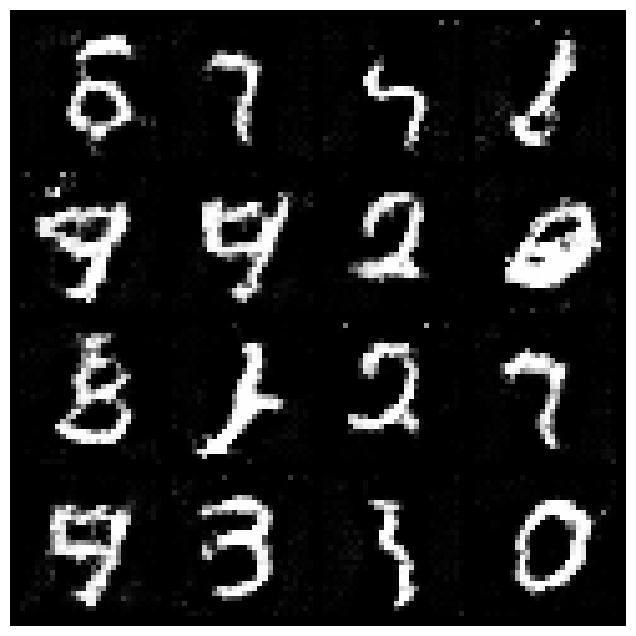

  0%|          | 0/938 [00:00<?, ?batch/s]

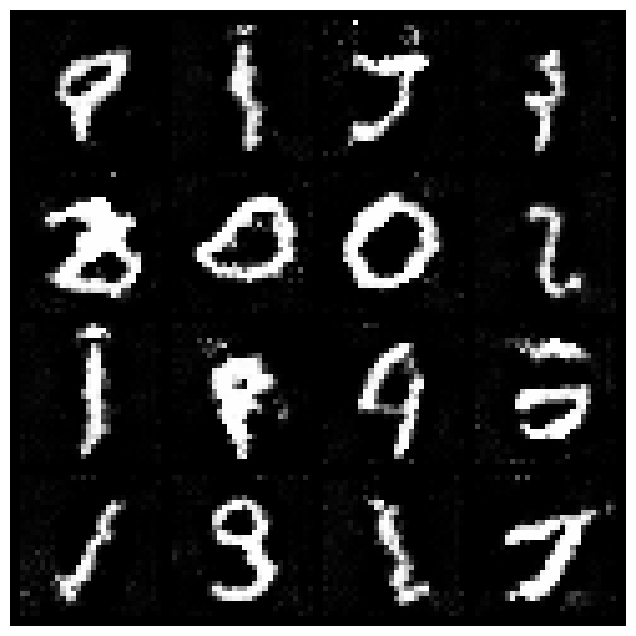

  0%|          | 0/938 [00:00<?, ?batch/s]

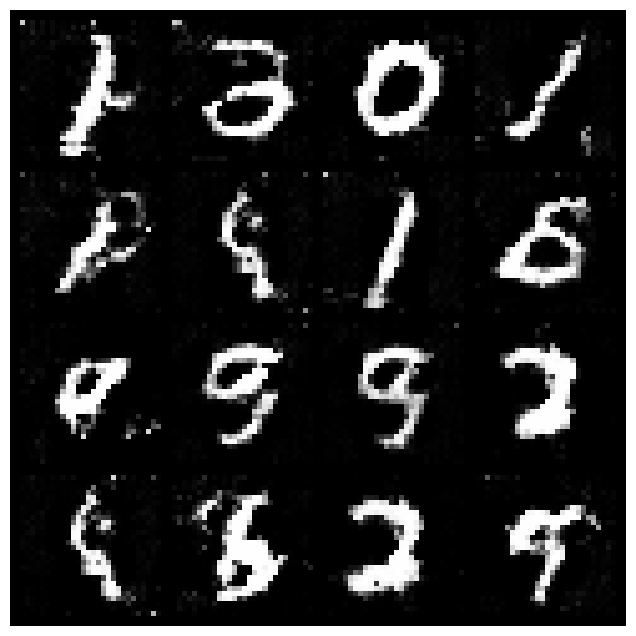

  0%|          | 0/938 [00:00<?, ?batch/s]

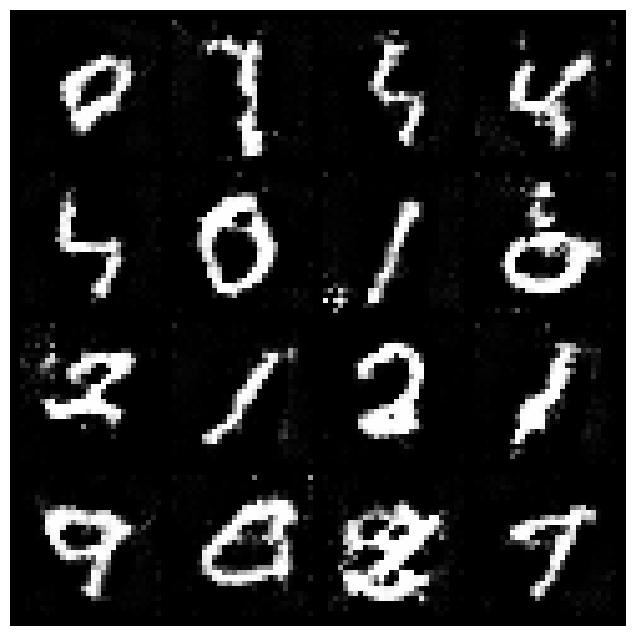

  0%|          | 0/938 [00:00<?, ?batch/s]

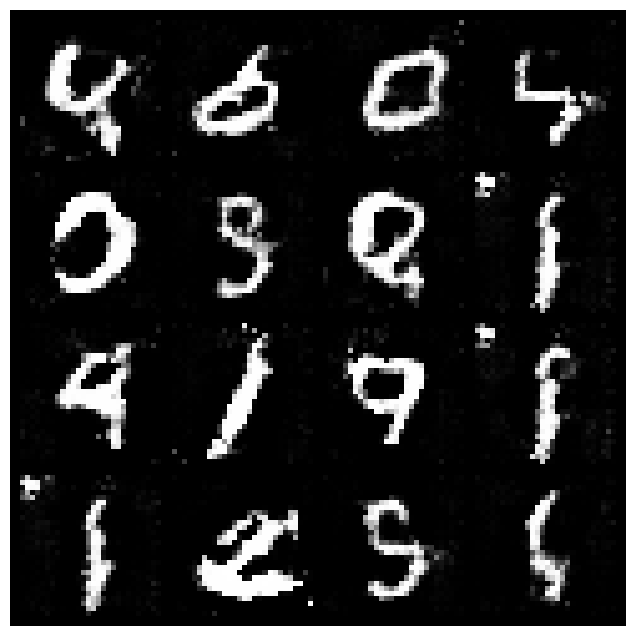

  0%|          | 0/938 [00:00<?, ?batch/s]

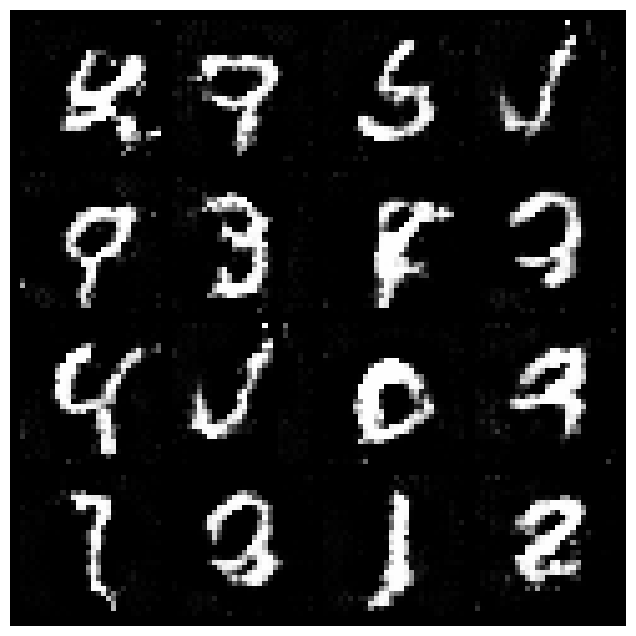

  0%|          | 0/938 [00:00<?, ?batch/s]

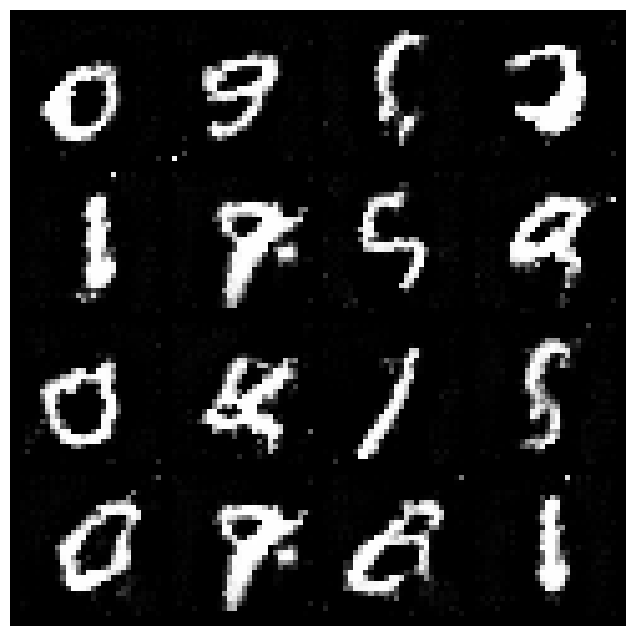

In [8]:
###################################
#  Training loop
###################################
print("Starting training...")
for epoch in range(num_epochs):
    for i, (imgs, _) in (
        pbar := tqdm(enumerate(dataloader), total=len(dataloader), unit='batch')
    ):
        batch_size_curr = imgs.size(0)
        real_imgs = imgs.to(device)

        # Create labels for real and fake
        real_labels = torch.ones(batch_size_curr, device=device)
        fake_labels = torch.zeros(batch_size_curr, device=device)

        # ============================
        # Train Discriminator
        # ============================
        optimizer_D.zero_grad()

        # Sample latent vector and generate fake images
        latent, cat_codes, cont_codes = sample_latent(batch_size_curr)
        fake_imgs = G(latent)

        # Discriminator outputs on real images
        d_real, _, _ = D(real_imgs)
        # Discriminator outputs on fake images
        d_fake, _, _ = D(fake_imgs.detach())

        loss_D_real = criterion_adv(d_real, real_labels)
        loss_D_fake = criterion_adv(d_fake, fake_labels)
        loss_D = loss_D_real + loss_D_fake

        loss_D.backward()
        optimizer_D.step()

        # ============================
        # Train Generator and Info (Q) network together
        # ============================
        optimizer_G.zero_grad()
        optimizer_info.zero_grad()

        # Generate fake images
        latent, cat_codes, cont_codes = sample_latent(batch_size_curr)
        fake_imgs = G(latent)
        d_fake, q_cat_logits, q_cont_mu = D(fake_imgs)

        # Adversarial loss: generator wants discriminator to label fake images as real
        loss_G_adv = criterion_adv(d_fake, real_labels)
        # Mutual information loss for categorical latent code
        loss_info_cat = criterion_cat(q_cat_logits, cat_codes)
        # Mutual information loss for continuous latent code
        loss_info_cont = criterion_cont(q_cont_mu, cont_codes)
        loss_info = loss_info_cat + loss_info_cont

        loss_G = loss_G_adv + lambda_info * loss_info

        loss_G.backward()
        optimizer_G.step()
        optimizer_info.step()

        pbar.set_description(f'[epoch {epoch+1}/{num_epochs}] G_loss: {loss_G.item():.4f} D_loss: {loss_D.item():.4f} Info_cat: {loss_info_cat.item():.4f} Info_cont: {loss_info_cont.item():.4f}')

    # Optionally, display some generated images every epoch:
    with torch.no_grad():
        latent, _, _ = sample_latent(16)
        fake_imgs = G(latent)
        fake_imgs = denorm(fake_imgs)
        grid = torch.cat([fake_imgs])
        plt.figure(figsize=(8,8))
        plt.axis("off")
        plt.imshow(torchvision.utils.make_grid(grid, nrow=4, normalize=True).permute(1,2,0).cpu().numpy())
        plt.show()


In [9]:
import torchvision.utils as vutils
import numpy as np

def denorm(img):
    # Scale image tensor from [-1, 1] to [0, 1]
    return (img + 1) / 2

def visualize_generated_images(G, num_images=16, nrow=4):
    """
    Generates and displays a grid of images from the generator G using sampled latent vectors.

    Args:
        G (nn.Module): The generator network.
        num_images (int): Number of images to generate.
        nrow (int): Number of images in each row of the grid.
    """
    G.eval()  # set generator to evaluation mode
    with torch.no_grad():
        latent, _, _ = sample_latent(num_images)  # sample latent codes using the provided function
        fake_imgs = G(latent)
        fake_imgs = denorm(fake_imgs)  # convert images to [0,1]
        grid = vutils.make_grid(fake_imgs, nrow=nrow, normalize=True)

    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Generated Images")
    plt.imshow(np.transpose(grid.cpu().numpy(), (1,2,0)))
    plt.show()



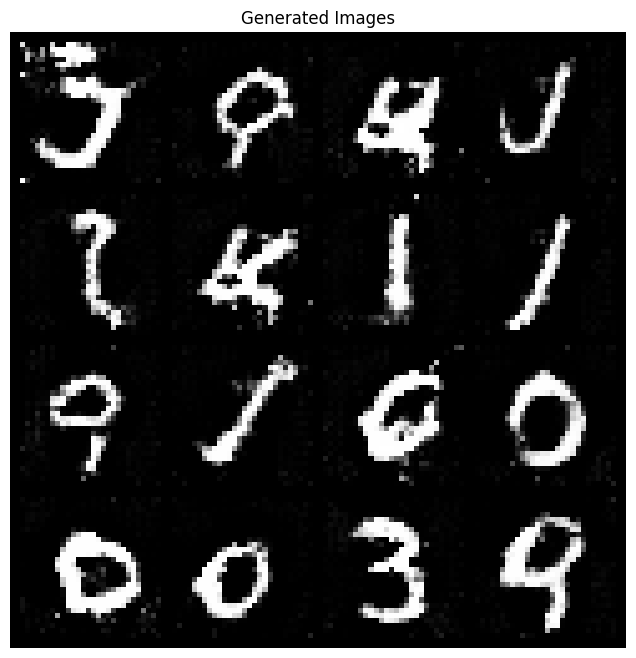

In [10]:
# Call the visualization function to display generated images
visualize_generated_images(G, num_images=16, nrow=4)


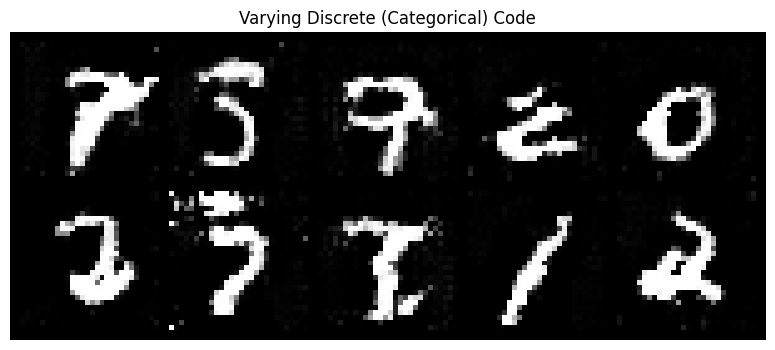

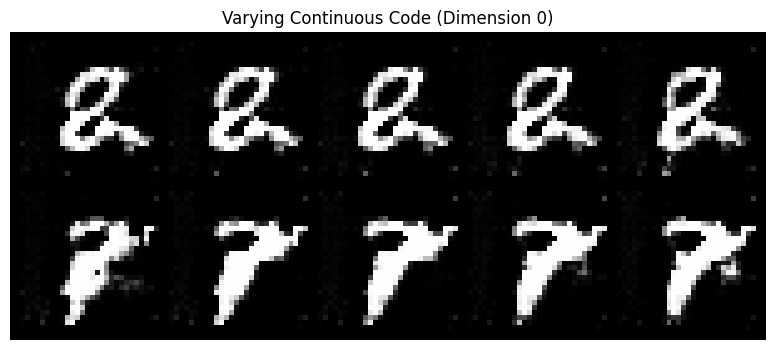

In [11]:
import torch
import torchvision
import matplotlib.pyplot as plt

def denorm(img):
    """Convert image tensor from [-1,1] to [0,1]."""
    return (img + 1) / 2

def generate_images_varying_cat(G, fixed_noise, fixed_cont, n_classes):
    """
    Generates one image for each category by varying the categorical code.

    Args:
        G (nn.Module): The InfoGAN generator.
        fixed_noise (Tensor): Fixed noise vector of shape (1, z_dim).
        fixed_cont (Tensor): Fixed continuous latent codes of shape (1, c_cont_dim).
        n_classes (int): Number of discrete classes.

    Returns:
        Tensor: Generated images of shape (n_classes, channels, H, W).
    """
    G.eval()
    images = []
    for i in range(n_classes):
        # Create a one-hot vector for category i.
        cat = torch.zeros(1, c_cat_dim, device=device)
        cat[0, i] = 1
        # Concatenate fixed noise, categorical code, and fixed continuous codes.
        latent = torch.cat([fixed_noise, cat, fixed_cont], dim=1)
        with torch.no_grad():
            img = G(latent)
        images.append(img)
    images = torch.cat(images, dim=0)
    return images

def generate_images_varying_cont(G, fixed_noise, fixed_cat, cont_dim=0, n_steps=10):
    """
    Generates images by varying one dimension of the continuous latent code.

    Args:
        G (nn.Module): The InfoGAN generator.
        fixed_noise (Tensor): Fixed noise vector of shape (1, z_dim).
        fixed_cat (Tensor): Fixed categorical code as a one-hot vector of shape (1, c_cat_dim).
        cont_dim (int): Which continuous dimension to vary.
        n_steps (int): Number of variations along that dimension.

    Returns:
        Tensor: Generated images of shape (n_steps, channels, H, W).
    """
    G.eval()
    images = []
    # Start with a baseline continuous code.
    fixed_cont = torch.rand(1, c_cont_dim, device=device) * 2 - 1
    # Vary the chosen continuous dimension from -1 to 1.
    for v in torch.linspace(-1, 1, steps=n_steps, device=device):
        cont = fixed_cont.clone()
        cont[0, cont_dim] = v
        latent = torch.cat([fixed_noise, fixed_cat, cont], dim=1)
        with torch.no_grad():
            img = G(latent)
        images.append(img)
    images = torch.cat(images, dim=0)
    return images

# Example usage:

# Assume these dimensions and device are already defined:
# z_dim, c_cat_dim, c_cont_dim, device
# For example:
# z_dim = 62; c_cat_dim = 10; c_cont_dim = 2; device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate a fixed noise vector and fixed continuous codes.
fixed_noise = torch.rand(1, z_dim, device=device) * 2 - 1
fixed_cont = torch.rand(1, c_cont_dim, device=device) * 2 - 1

# 1. Vary the discrete code: produce one image per class.
images_cat = generate_images_varying_cat(G, fixed_noise, fixed_cont, n_classes=c_cat_dim)
grid_cat = torchvision.utils.make_grid(denorm(images_cat), nrow=5)
plt.figure(figsize=(10, 4))
plt.title("Varying Discrete (Categorical) Code")
plt.imshow(grid_cat.permute(1, 2, 0).cpu().numpy())
plt.axis("off")
plt.show()

# 2. Vary a continuous code: fix categorical code (e.g., class 0) and vary one continuous dimension.
fixed_cat = torch.zeros(1, c_cat_dim, device=device)
fixed_cat[0, 0] = 1  # Fix to category 0 (for example)
images_cont = generate_images_varying_cont(G, fixed_noise, fixed_cat, cont_dim=0, n_steps=10)
grid_cont = torchvision.utils.make_grid(denorm(images_cont), nrow=5)
plt.figure(figsize=(10, 4))
plt.title("Varying Continuous Code (Dimension 0)")
plt.imshow(grid_cont.permute(1, 2, 0).cpu().numpy())
plt.axis("off")
plt.show()
